In [3]:
#Verifying Pytorch Installation
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

CUDA available: True
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA version: 11.8


In [4]:
#Verifying Model Installation
from transformers import AutoTokenizer, AutoModelForSequenceClassification
print("Transformers installed correctly")

Transformers installed correctly


In [5]:
# Loading processed Twitter data
import pandas as pd

twitter = pd.read_csv("data/processed/twitter.csv")

print(twitter.shape)
print(twitter.head())
print(twitter["label"].value_counts())


(5791, 2)
                                                text  label
0  kickers on my watchlist xide tit soq pnk cpw b...      2
1  user: aap movie. 55% return for the fea/geed i...      2
2  user i'd be afraid to short amzn - they are lo...      2
3                                    mnta over 12.00      2
4                                      oi over 21.37      2
label
2    3685
0    2106
Name: count, dtype: int64


In [6]:
#Creating Split for Twitter for Local Training  
from sklearn.model_selection import train_test_split

# Separating inputs and labels
X = twitter["text"]
y = twitter["label"]

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# From the 30%,we take 50% for validation (=> 15% of total)
X_val, _, y_val, _ = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))

print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation label distribution:")
print(y_val.value_counts(normalize=True))


Train size: 4053
Validation size: 869

Train label distribution:
label
2    0.636319
0    0.363681
Name: proportion, dtype: float64

Validation label distribution:
label
2    0.636364
0    0.363636
Name: proportion, dtype: float64


In [7]:
#Loading Finbert Model
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "ProsusAI/finbert"

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Loading model (3 sentiment labels)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

# Moving model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("FinBERT loaded successfully on:", device)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

C:\ProgramData\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rstar\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERT loaded successfully on: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [8]:
#Importing Required Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

#Loading Finbert Tokenizer
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

In [9]:
#Class for Dataset
class FinSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [13]:
#Creating Twitter Clients Datasets - > Objects of DatasetClass
#Also Renaming for clarity (Twitter client)
tw_train = X_train
tw_val   = X_val
y_tw_train = y_train
y_tw_val   = y_val

tw_train_dataset = FinSentimentDataset(tw_train, y_tw_train, tokenizer)
tw_val_dataset   = FinSentimentDataset(tw_val, y_tw_val, tokenizer)

In [16]:
#Creating DataLoaders
tw_train_loader = DataLoader(tw_train_dataset, batch_size=16, shuffle=True)
tw_val_loader   = DataLoader(tw_val_dataset, batch_size=16, shuffle=False)

In [17]:
"""
Step - Training
Defining the local training loop(single client)
Concept - Each Client locally training the model
"""
#Defining Optimiser(Adam), Loss and Scheduler
import torch
from torch.optim import AdamW #Adam is the standard used for transformers models
from transformers import get_linear_schedule_with_warmup

# Number of labels: 3 (neg, neutral, positive)
num_labels = 3

model.train()

optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(tw_train_loader) * 3  # 3 epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
#Local Training Loop
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
#Sanity Traning to see Pipeline Corectness, Verify Gpu Usuage, Ensure Loss Decreases and Catch Bugs if any
epochs = 3

for epoch in range(epochs):
    avg_loss = train_one_epoch(
        model,
        tw_train_loader,
        optimizer,
        scheduler,
        device
    )
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:44<00:00,  5.65it/s]


Epoch 1/3 - Loss: 0.6842


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:44<00:00,  5.74it/s]


Epoch 2/3 - Loss: 0.4243


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [00:44<00:00,  5.71it/s]

Epoch 3/3 - Loss: 0.2606


In [32]:
"""
Sanity Training - Results, Understanding and Upcoming Work

#Results
Epoch 1/3 - Loss: 0.6842
Epoch 2/3 - Loss: 0.4243
Epoch 3/3 - Loss: 0.2606

Loss is monotonically decreasing
Model is learning meaningful patterns
Labels and tokenization are correct
No gradient explosion / instability
FinBERT fine-tuning is successful on this client

#Upcoming Work
1.Local Evaluation for Twitter
2.Repeat Sanity Training for News and Reports Client 
3.Federated Setup - FedAvg and FedProx
"""

'\nSanity Training - Results, Understanding and Upcoming Work\n\n#Results\nEpoch 1/3 - Loss: 0.6842\nEpoch 2/3 - Loss: 0.4243\nEpoch 3/3 - Loss: 0.2606\n\nLoss is monotonically decreasing\nModel is learning meaningful patterns\nLabels and tokenization are correct\nNo gradient explosion / instability\nFinBERT fine-tuning is successful on this client\n\n#Upcoming Work\n1.Local Evaluation for Twitter\n2.Repeat Sanity Training for News and Reports Client \n3.Federated Setup - FedAvg and FedProx\n'

In [23]:
#Local Evaluation
#Importing required evaluation libs
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

#Putting the model in evaluation mode - This disables Dropout and Gradient Computation
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [25]:
#Evaluation Loop
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tw_val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [26]:
#Metrics Computation
accuracy = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="weighted"
)

print(f"Validation Accuracy : {accuracy:.4f}")
print(f"Precision           : {precision:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"F1-score            : {f1:.4f}")

Validation Accuracy : 0.8147
Precision           : 0.8126
Recall              : 0.8147
F1-score            : 0.8130


In [27]:
#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[223  93]
 [ 68 485]]


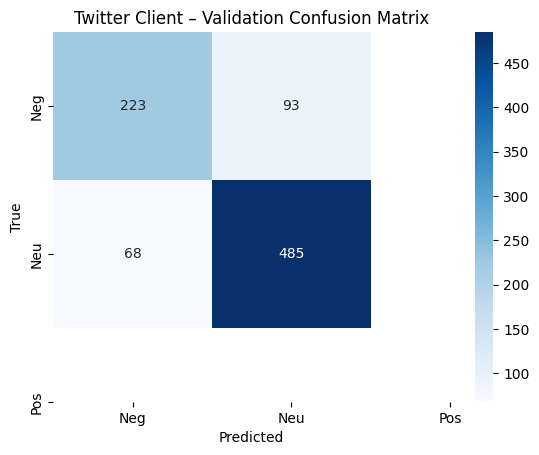

In [29]:
#Heatmap of Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Twitter Client – Validation Confusion Matrix")
plt.show()

In [30]:
import os

os.makedirs("models", exist_ok=True)
os.makedirs("models/twitter_local_finbert", exist_ok=True)


In [31]:
#Saving the Local Model
model.save_pretrained("models/twitter_local_finbert")
tokenizer.save_pretrained("models/twitter_local_finbert")

print("Twitter local FinBERT model saved successfully")

Twitter local FinBERT model saved successfully


In [33]:
tokenizer.save_pretrained("models/twitter_local_finbert")

('models/twitter_local_finbert\\tokenizer_config.json',
 'models/twitter_local_finbert\\special_tokens_map.json',
 'models/twitter_local_finbert\\vocab.txt',
 'models/twitter_local_finbert\\added_tokens.json')

In [34]:
#Checking if the Model Loads
from transformers import AutoTokenizer
AutoTokenizer.from_pretrained("models/twitter_local_finbert")
print("Twitter tokenizer OK")

Twitter tokenizer OK


In [9]:
import os
os.makedirs("data/splits", exist_ok=True)

# Saving Twitter validation split for Global Model Evaluation
X_val.to_csv("data/splits/twitter_val_text.csv", index=False)
y_val.to_csv("data/splits/twitter_val_labels.csv", index=False)

print("Twitter validation split saved")

Twitter validation split saved
